In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [76]:
file_name = "./Data/HINDALCO-I.NFO.csv"

df = (
    pd.read_csv(file_name)
      .drop(columns=["Date"])
      .set_index("Time")
)

df.index = pd.to_datetime(df.index, format="%H:%M:%S.%f")

df


,BID_PRICE,ASK_PRICE,LTQ,OpenInterest
Time,,,,
1900-01-01 09:15:00,861.10,862.25,1400.0,62003200.0
1900-01-01 09:15:01,861.85,862.90,15400.0,62003200.0
1900-01-01 09:15:02,861.85,862.90,15400.0,62003200.0
1900-01-01 09:15:03,862.30,863.90,23100.0,62003200.0
1900-01-01 09:15:04,863.00,864.20,23100.0,62003200.0
...,...,...,...,...
1900-01-01 15:29:56,854.30,854.65,7501200.0,62227200.0
1900-01-01 15:29:57,854.30,854.65,7501200.0,62227200.0
1900-01-01 15:29:58,854.30,854.65,7501200.0,62227200.0


In [77]:
df["MID_PRICE"] = (df["BID_PRICE"] + df["ASK_PRICE"])/2
df

,BID_PRICE,ASK_PRICE,LTQ,OpenInterest,MID_PRICE
Time,,,,,
1900-01-01 09:15:00,861.10,862.25,1400.0,62003200.0,861.675
1900-01-01 09:15:01,861.85,862.90,15400.0,62003200.0,862.375
1900-01-01 09:15:02,861.85,862.90,15400.0,62003200.0,862.375
1900-01-01 09:15:03,862.30,863.90,23100.0,62003200.0,863.100
1900-01-01 09:15:04,863.00,864.20,23100.0,62003200.0,863.600
...,...,...,...,...,...
1900-01-01 15:29:56,854.30,854.65,7501200.0,62227200.0,854.475
1900-01-01 15:29:57,854.30,854.65,7501200.0,62227200.0,854.475
1900-01-01 15:29:58,854.30,854.65,7501200.0,62227200.0,854.475


Calculating 

    - the mid price difference
    - the volume difference
    

In [78]:
df["mid_change"]  = df["MID_PRICE"].diff()
df["volume_change"] = df["LTQ"].diff()
df.head()

,BID_PRICE,ASK_PRICE,LTQ,OpenInterest,MID_PRICE,mid_change,volume_change
Time,,,,,,,
1900-01-01 09:15:00,861.10,862.25,1400.0,62003200.0,861.675,NaN,NaN
1900-01-01 09:15:01,861.85,862.90,15400.0,62003200.0,862.375,0.700,14000.0
1900-01-01 09:15:02,861.85,862.90,15400.0,62003200.0,862.375,0.000,0.0
1900-01-01 09:15:03,862.30,863.90,23100.0,62003200.0,863.100,0.725,7700.0
1900-01-01 09:15:04,863.00,864.20,23100.0,62003200.0,863.600,0.500,0.0


    Calculating order flow imbalance based on price direction

In [79]:
df["OFI_second"] = 0

# For rows where mid_change is positive, put the value of volume_change into the column OFI_second.

df.loc[df["mid_change"]>0,"OFI_second"] = df["volume_change"]

# If the mid price goes down, record the volume as negative in OFI_second.

df.loc[df['mid_change'] < 0, 'OFI_second'] = -df['volume_change']


In [80]:
df.head()

,BID_PRICE,ASK_PRICE,LTQ,OpenInterest,MID_PRICE,mid_change,volume_change,OFI_second
Time,,,,,,,,
1900-01-01 09:15:00,861.10,862.25,1400.0,62003200.0,861.675,NaN,NaN,0
1900-01-01 09:15:01,861.85,862.90,15400.0,62003200.0,862.375,0.700,14000.0,14000
1900-01-01 09:15:02,861.85,862.90,15400.0,62003200.0,862.375,0.000,0.0,0
1900-01-01 09:15:03,862.30,863.90,23100.0,62003200.0,863.100,0.725,7700.0,7700
1900-01-01 09:15:04,863.00,864.20,23100.0,62003200.0,863.600,0.500,0.0,0


    Aggregate to 1 minute

In [81]:
# Step 3.1: Create minute-level timestamp for grouping from index
df['minute'] = df.index.floor('1min')

# Step 3.2: Aggregate second-level data to minute-level
minute_df = df.groupby('minute').agg({
    'OFI_second': 'sum',           # Sum all 60 second OFIs
    'volume_change': 'sum',         # Total volume in the minute
    'MID_PRICE': ['first', 'last'], # Start and end price
    'BID_PRICE': 'mean',            # Average bid (optional)
    'ASK_PRICE': 'mean',            # Average ask (optional)
}).reset_index()

# Step 3.3: Flatten column names (multi-level index from agg)
minute_df.columns = ['minute', 'OFI_minute', 'total_volume', 
                     'mid_start', 'mid_end', 'avg_bid', 'avg_ask']

# Step 3.4: Calculate minute-level price change
minute_df['price_change'] = minute_df['mid_end'] - minute_df['mid_start']

# Step 3.5: Calculate minute return (log return)
minute_df['minute_return'] = np.log(minute_df['mid_end'] / minute_df['mid_start'])

print(minute_df.head())

               minute  OFI_minute  total_volume  mid_start  mid_end  \
0 1900-01-01 09:15:00       16800       63700.0    861.675  862.550   
1 1900-01-01 09:16:00        9800       58100.0    862.575  861.525   
2 1900-01-01 09:17:00      -55300       86800.0    861.500  857.800   
3 1900-01-01 09:18:00       -8400       56700.0    857.875  858.075   
4 1900-01-01 09:19:00        8400       82600.0    857.975  858.250   

      avg_bid     avg_ask  price_change  minute_return  
0  862.568333  863.219167         0.875       0.001015  
1  861.541667  861.968333        -1.050      -0.001218  
2  859.610000  860.024167        -3.700      -0.004304  
3  857.871667  858.243333         0.200       0.000233  
4  858.254167  858.595833         0.275       0.000320  


<Axes: >

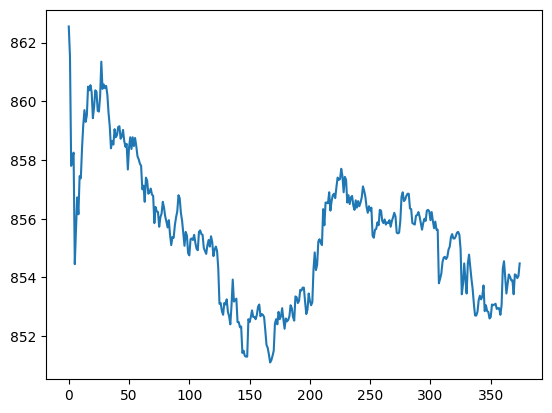

In [98]:
minute_df["mid_end"].plot()

In [82]:
minute_df

,minute,OFI_minute,total_volume,mid_start,mid_end,avg_bid,avg_ask,price_change,minute_return
0,1900-01-01 09:15:00,16800,63700.0,861.675,862.550,862.568333,863.219167,0.875,0.001015
1,1900-01-01 09:16:00,9800,58100.0,862.575,861.525,861.541667,861.968333,-1.050,-0.001218
2,1900-01-01 09:17:00,-55300,86800.0,861.500,857.800,859.610000,860.024167,-3.700,-0.004304
3,1900-01-01 09:18:00,-8400,56700.0,857.875,858.075,857.871667,858.243333,0.200,0.000233
4,1900-01-01 09:19:00,8400,82600.0,857.975,858.250,858.254167,858.595833,0.275,0.000320
...,...,...,...,...,...,...,...,...,...
371,1900-01-01 15:26:00,3500,18900.0,854.100,854.075,853.960833,854.072500,-0.025,-0.000029
372,1900-01-01 15:27:00,-2800,25900.0,854.050,853.975,853.871667,854.123333,-0.075,-0.000088
373,1900-01-01 15:28:00,22400,30800.0,853.975,854.050,853.844167,854.024167,0.075,0.000088
374,1900-01-01 15:29:00,4900,19600.0,854.125,854.475,854.112500,854.382500,0.350,0.000410


In [83]:
# Step 1: Create directional target (instead of raw returns)
minute_df = minute_df.copy()
minute_df['target_return'] = minute_df['minute_return'].shift(-1)

# Step 2: Create classification labels
# Option A: 3-class (Up, Down, Neutral)
threshold = 0.0001  # 0.01% threshold
minute_df['target_direction'] = np.where(
    minute_df['target_return'] > threshold, 1,      # Up
    np.where(minute_df['target_return'] < -threshold, -1,  # Down
             0)  # Neutral
)

# Option B: 2-class (simpler - Up vs Down only)
minute_df['target_binary'] = np.where(
    minute_df['target_return'] > 0, 1, 0  # 1=Up, 0=Down
)

# Step 3: Drop last row
minute_df = minute_df[:-1].copy()

# Step 4: Features and target
X = minute_df[['OFI_minute']]
y = minute_df['target_binary']  # or 'target_direction' for 3-class

# Step 5: Train/test split
split_idx = int(len(X) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Step 6: Classification model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression()
model.fit(X_train, y_train)

# Step 7: Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Step 8: Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Size: {len(y_test)} minutes")
print(f"Accuracy: {accuracy:.4f}")
print(f"Baseline (always predict majority class): {max(y_test.mean(), 1-y_test.mean()):.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))
print(f"\nOFI Coefficient: {model.coef_[0][0]:.10f}")

Test Set Size: 113 minutes
Accuracy: 0.5310
Baseline (always predict majority class): 0.5044

Confusion Matrix:
[[51  6]
 [47  9]]

Classification Report:
              precision    recall  f1-score   support

        Down       0.52      0.89      0.66        57
          Up       0.60      0.16      0.25        56

    accuracy                           0.53       113
   macro avg       0.56      0.53      0.46       113
weighted avg       0.56      0.53      0.46       113


OFI Coefficient: -0.0000104945


In [ ]:
model = DecisionTreeClassifier(max_depth=7)
model.fit(X,y)

,criterion,'gini'
,splitter,'best'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [85]:
# Step 1: 60% train, 40% remaining
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)

# Step 2: Split 40% into 50/50 → each gets 20% of original
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [86]:
accuracy_score(y_test,model.predict(X_test))

0.5866666666666667

In [87]:
accuracy_score(y_val,model.predict(X_val))

0.5733333333333334

In [88]:
accuracy_score(y_train,model.predict(X_train))

0.6488888888888888

In [94]:
confusion_matrix(y_train,model.predict(X_train))

array([[116,   5],
       [ 74,  30]])

In [96]:
print(classification_report(y_train,model.predict(X_train)
))

              precision    recall  f1-score   support

           0       0.61      0.96      0.75       121
           1       0.86      0.29      0.43       104

    accuracy                           0.65       225
   macro avg       0.73      0.62      0.59       225
weighted avg       0.72      0.65      0.60       225



In [89]:
depth_hyperparams = range(1,50,2)

In [90]:
training_acc =  []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = DecisionTreeClassifier(random_state=42, max_depth=d)
        
    #Fit model to the training data
    test_model.fit(X_train, y_train)
    #Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    #Calculate validation accuracy score and append to `validation_acc`
    validation_acc.append(test_model.score(X_val,y_val))

    print("Training Accuracy Scores:", training_acc[:3])
    print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.5777777777777777]
Validation Accuracy Scores: [0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889]
Validation Accuracy Scores: [0.56, 0.52]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Traini

Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888889, 0.6533333333333333]
Validation Accuracy Scores: [0.56, 0.52, 0.56]
Training Accuracy Scores: [0.5777777777777777, 0.6088888888888

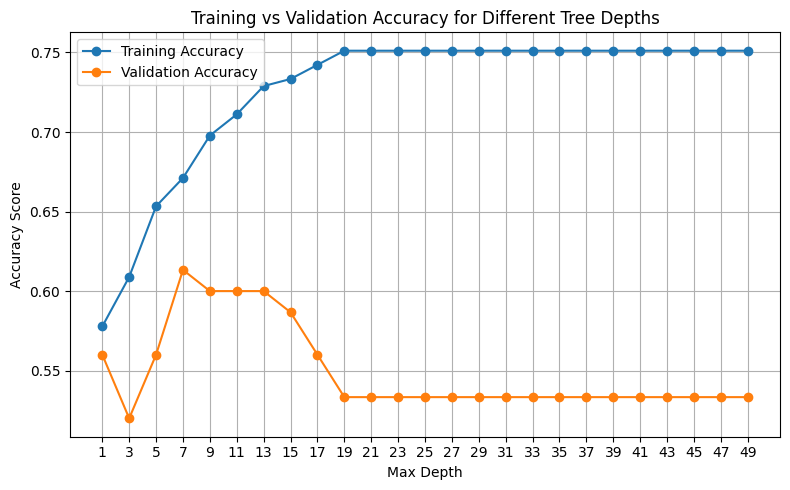

In [91]:
plt.figure(figsize=(8,5))

plt.plot(depth_hyperparams, training_acc, marker='o', label="Training Accuracy")
plt.plot(depth_hyperparams, validation_acc, marker='o', label="Validation Accuracy")


plt.xticks(depth_hyperparams)

plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Training vs Validation Accuracy for Different Tree Depths")

plt.grid(True)  # Add grid
plt.legend()
plt.tight_layout()
plt.show()
